# Importing and Tidying the Data

In [1]:
# import stuff
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
%matplotlib inline

In [3]:
#import the data from csv file with a series of NAN values 
df1 = pd.read_csv('./../data/highered_00004.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
df1 = df1.drop(['REFID'], axis=1)
df2 = pd.read_csv('./../data/highered_00007.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
df3 = pd.read_csv('./../data/highered_00008.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
dfm = df1.merge(df2,  on=['PERSONID', 'YEAR', 'WEIGHT', 'SAMPLE', 'SURID'])

In [4]:
# explanation of the survey https://highered.ipums.org/highered/survey_designs.shtml

# Respondents from each of these three surveys with science or engineering degrees                               ##
# or occupations are compiled into one dataset: the SESTAT (the Scientists and Engineers Statistical Data System)##
df = dfm.merge(df3, on=['PERSONID', 'YEAR', 'SURID'])


In [5]:
df_employed = df[df['LFSTAT']==1]
df_employed_small = df_employed.drop(['CTZUS', 'WEIGHT', 'WRKG', 'NRREA','FNVS', 'CHTOT', 'CPI2009C', 'PERSONID', 'LFSTAT','BA03Y5', 'LOOKWK'], axis=1)
#df_employed_small.info()

In [6]:
#df_employed_l = df_employed_small[df_employed_small.SALARY != 150000]
#df_employed_l = df_employed_small[df_employed_small['NDGMEMG']==3].dropna()
df_employed_l = df_employed_small.dropna()

Next we use pandas' correlation funcion and seaborns heatmap to get a general idea of how the features are related to each other.

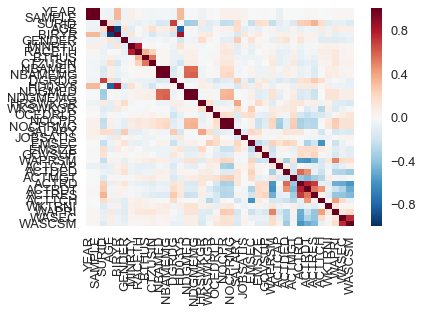

In [134]:
sns.heatmap(df_employed_l.corr())

In [135]:
df_employed_l.corr()['SALARY']

YEAR        0.047753
SAMPLE      0.049694
SURID       0.193761
AGE         0.186057
BIRYR      -0.162161
GENDER      0.257586
MINRTY     -0.102562
RACETH     -0.101382
BTHUS      -0.055799
CTZUSIN     0.012500
NBAMED     -0.037537
NBAMEMG    -0.034085
DGRDG       0.263496
HD03Y5     -0.167808
NDGMED     -0.010046
NDGMEMG    -0.001453
HRSWKGR     0.403946
WKSWKGR     0.176768
OCEDRLP    -0.128177
NOCPR      -0.091245
NOCPRMG    -0.056801
SALARY      1.000000
JOBSATIS   -0.140447
EMSEC       0.215927
EMSIZE      0.169909
GOVSUP      0.022820
WAPRSM     -0.034008
ACTCAP      0.042460
ACTDED      0.126313
ACTMGT      0.119822
ACTRD       0.115217
ACTRDT     -0.012041
ACTRES      0.036424
ACTTCH     -0.183005
WKTRNI      0.007476
WAPRI      -0.172204
WASEC      -0.133979
WASCSM     -0.141206
Name: SALARY, dtype: float64

Looks like many of the columns are catagorical and has been stored in the same column as numbers, such as the field of major, highest degree and etc. They need to be treated that way. Here pandas get_dummies are used for this purpose. 

In [7]:
df_employed_d = pd.get_dummies(df_employed_l, columns=['RACETH','NBAMED', 'NBAMEMG', 'NDGMED', 'EMSEC','EMSIZE', 'GOVSUP', 'NDGMEMG', 'OCEDRLP', 'WAPRSM', 'WAPRI', 'WKTRNI', 'WASEC', 'NOCPR','WASCSM', 'NOCPRMG', 'SAMPLE', 'HD03Y5', 'DGRDG', 'JOBSATIS','SURID','HRSWKGR','WKSWKGR'], drop_first=True)

In [137]:
X = df_employed_d.drop(['SALARY'], axis=1)
y = df_employed_d['SALARY']

#import the machine learning algorithm packages
# Import modules of linear regresssion, evaluation, and train test split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# Import Lasso
from sklearn.linear_model import Lasso
# Import Ridge
from sklearn.linear_model import Ridge


#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg
reg = Ridge()


# Fit the model to the data
reg.fit(X_train,y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


0.516113551273
Root Mean Squared Error: 27519.51410199216


Only looking at the data where salary is not 0. The R2 improved slightly. 

In [8]:
df_employed_no = df_employed_d[(df_employed_d['SALARY']>0)]
X = df_employed_no.drop(['SALARY'], axis=1)
y = df_employed_no['SALARY']

#import the machine learning algorithm packages
# Import modules of linear regresssion, evaluation, and train test split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# Import Lasso
from sklearn.linear_model import Lasso
# Import Ridge
from sklearn.linear_model import Ridge


#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg
reg = Ridge()


# Fit the model to the data
reg.fit(X_train,y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

# Cap the predicted value at 150000 as in the original data set 
y_pred = np.clip(y_pred, 0, 150000)

# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


0.520050837381
Root Mean Squared Error: 27131.84390622173


In [96]:

#make functions to calculate coefficient of determination 
from statistics import mean

def squared_error(ys_orig,ys_line):
    return sum((ys_line - ys_orig) * (ys_line - ys_orig))

def coefficient_of_determination(ys_orig,ys_line):
    y_mean_line = [mean(ys_orig) for y in ys_orig]
    squared_error_regr = squared_error(ys_orig, ys_line)
    squared_error_y_mean = squared_error(ys_orig, y_mean_line)
    return 1 - (squared_error_regr/squared_error_y_mean)



print(coefficient_of_determination(y_test, y_pred))

KeyboardInterrupt: 

#### The ridge and simple linear regression both give the determination coefficient ($R^2$) result of 0.51. It is not bad considering some essential fact contributing to the salary is unknown: level of the position, location of the job,  and company pay ability. This next cell shows a histogram of the actual salaries and the predicted salaries. We see the distribution of predected salary is more centrally located around the mean. Can this give us a hint as to what to do next?

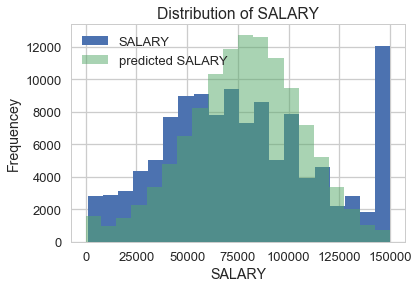

In [139]:
plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_pred,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()

In [104]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary() )
#m3 = ols(formula='SALARY ~ ALL',data = df_employed_d).fit()
#print(m3.summary())

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     345.5
Date:                Wed, 18 Apr 2018   Prob (F-statistic):               0.00
Time:                        22:09:18   Log-Likelihood:            -4.1983e+05
No. Observations:               36149   AIC:                         8.399e+05
Df Residuals:                   36015   BIC:                         8.411e+05
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
YEAR              161.8095    100.120     

Above gives the result from the linear regresssion by statsmodel. We see the correlation is statistically significant (p-value from the F-statistic). The R^2 score is consistent with what is given by sklearn linear models. 

How about polynomial regression? => not improving the result at degree =2. At degree =3, it is taking too long to finish running. 

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

df_sample = df_employed_no.sample(frac=0.01, random_state=42)

X_s = df_sample.drop(['SALARY'], axis=1)
y_s = df_sample['SALARY']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.3, random_state=42)



model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                   ('linear', LinearRegression())])

# fit to an order-2 polynomial data

model.fit(X_train, y_train)

# Compute predictions over the prediction space: y_pred
y_pred = model.predict(X_test)

# Print R^2 
print(model.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


-0.532332645709
Root Mean Squared Error: 48524.19561370276


I tried the log feature, it gave a slightly better result (0.5=>0.53) when taking a power of 6.

In [105]:
df_sample = df_employed_no
#.sample(frac=0.2, random_state=42)

X_s = df_sample.drop(['SALARY'], axis=1)
y_s = np.log(df_sample['SALARY'])**6

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.3, random_state=42)

reg = LinearRegression()

# fit to an order-2 polynomial data

reg.fit(X_train, y_train)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(X_test)

# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))



0.557497895581
Root Mean Squared Error: 400013.2123869626


In [24]:
#Use grid search for random forest regressor
# Import necessary modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
X = df_employed_no.drop(['SALARY'], axis=1)
y = df_employed_no['SALARY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

param_grid = {"n_estimators": [10, 30, 50],
              "max_features": [10, 30],
              "max_depth": [10, 100, 300]
              }

# Instantiate a logistic regression classifier: logreg
rfr = RandomForestRegressor()

# Instantiate the GridSearchCV object: logreg_cv
rfr_cv = GridSearchCV(rfr, param_grid, cv=5)

# Fit it to the data
rfr_cv.fit(X_train,y_train)

y_rfr_cv = rfr_cv.predict(X_test)

rmse_rfr_cv = np.sqrt(mean_squared_error(y_test,y_rfr_cv))

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfr_cv.best_params_)) 
print("Best score is {}".format(rfr_cv.best_score_))

# test data result
print("Score on the test data is: ", rfr_cv.score(X_test, y_test))

# Print RMSE
print("RBF Root Mean Squared Error: {}".format(rmse_rfr_cv))

Tuned Logistic Regression Parameters: {'max_depth': 300, 'max_features': 30, 'n_estimators': 30}
Best score is 0.4537295202072781
Score on the test data is:  0.452772934684
RBF Root Mean Squared Error: 28997.836862531163


0.591906333548
RBF Root Mean Squared Error: 25662.413415643365


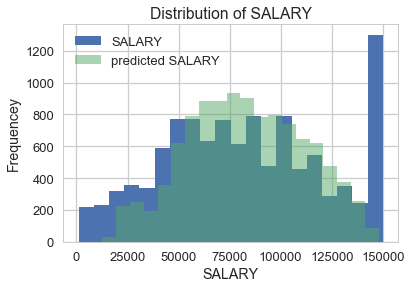

In [106]:
## Trying random forest regressor 
df_sample = df_employed_no
#.sample(frac=0.2, random_state=42)

X_s = df_sample.drop(['SALARY'], axis=1)
y_s = df_sample['SALARY']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.3, random_state=42)


from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, max_features=25, max_depth=300)

#rfr.fit(X,y)
# Use feature selection
#model = SelectFromModel(rfr, prefit=True)
#X_new = model.transform(X)

#train test split
#X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state=42)

y_rfr = rfr.fit(X_train, y_train).predict(X_test)

#y_rfr = np.clip(y_rfr, 0, 150000)

rmse_rfr = np.sqrt(mean_squared_error(y_test,y_rfr))

# Print R2
print(rfr.score(X_test, y_test))
#print(coefficient_of_determination(y_test, y_rfr))

# Print RMSE
print("RBF Root Mean Squared Error: {}".format(rmse_rfr))


plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_rfr,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()

Delete rows with 150000 salary and try the regression again. Linear regression:

0.49383128444
Root Mean Squared Error: 23613.140410293803


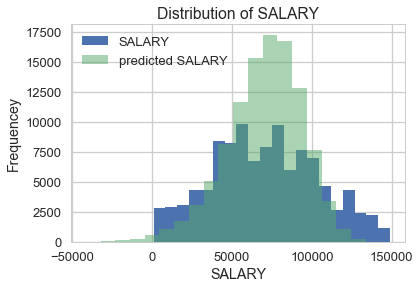

In [12]:
## Regression on data with less than 150000 salary


df_decap = df_employed_no[df_employed_no['SALARY']<150000]
X = df_decap.drop(['SALARY'], axis=1)
y = df_decap['SALARY']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
#y_pred = np.clip(y_pred, 0, 150000)

# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

# your turn

plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_pred,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()


Random forest regressor with less 150000 salary entries:

In [86]:
# Instantiate a random forest regressor
rfr = RandomForestRegressor(n_estimators=100, max_features=25, max_depth=100)

# Fit it to the data
rfr.fit(X_train,y_train)

y_rfr = rfr.predict(X_test)

rmse_rfr = np.sqrt(mean_squared_error(y_test,y_rfr))

# test data result
print("Score on the test data is: ", rfr.score(X_test, y_test))

# Print RMSE
print("Root Mean Squared Error: {}".format(rmse_rfr))


Score on the test data is:  0.537672853447
Root Mean Squared Error: 22567.362091646504


Use feature selection and try the regression again.

shape of X:  (389896, 183)
shape of X_new:  (389896, 29)
0.135619274011
Root Mean Squared Error: 36489.815943292066


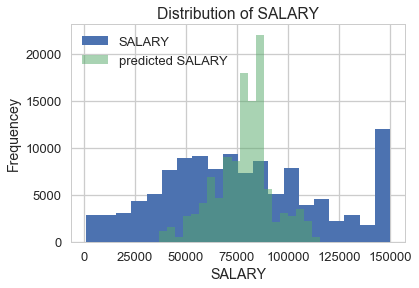

In [13]:
X = df_employed_no.drop(['SALARY'], axis=1)
y = df_employed_no['SALARY']

reg = LinearRegression()
reg.fit(X,y)

from sklearn.feature_selection import SelectFromModel
#Use feature selection
model = SelectFromModel(reg, prefit=True)
X_new = model.transform(X)

print("shape of X: ", X.shape)
print("shape of X_new: ", X_new.shape)
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state=42)

# Fit the model to the new data
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred = np.clip(y_pred, 0, 150000)


# Print R^2 
print(reg.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

# your turn

plt.hist(y_test, bins=20, label='SALARY')
plt.hist(y_pred,  bins=20, alpha=0.5, label='predicted SALARY')
plt.title("Distribution of SALARY")
plt.legend()
plt.xlabel("SALARY")
plt.ylabel("Frequencey")
plt.show()


In [ ]:
## Trying SVR 
from sklearn.svm import SVR

df_sample = df_employed_no.sample(frac=0.1, random_state=42)

X = df_sample.drop(['SALARY'], axis=1)
y = df_sample['SALARY']


#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


svr_rbf = SVR(kernel='rbf', C=120000, gamma=0.005)
#svr_lin = SVR(kernel='linear', C=1e3)
#svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X_train, y_train).predict(X_test)
#y_lin = svr_fit(X_train, y_train).predict(X_test)
#y_poly = svr_fit(X_train, y_train).predict(X_test)

rmse_rbf = np.sqrt(mean_squared_error(y_test,y_rbf))
#rmse_lin = np.sqrt(mean_squared_error(y_test,y_lin))
#rmse_poly = np.sqrt(mean_squared_error(y_test,y_poly))

# Print R^2 
print(svr_rbf.score(X_test, y_test))

# Print RMSE
print("RBF Root Mean Squared Error: {}".format(rmse_rbf))
#print("LIN Root Mean Squared Error: {}".format(rmse_lin))
#print("Poly Root Mean Squared Error: {}".format(rmse_poly))

In [17]:
# Trying to predict NOCPRMG or WAPRSM

In [22]:
#df_employed_clf = df_employed_no
df_employed_clf =[]
df_employed_clf = df_employed_l[df_employed_l['SALARY']>0]
df_employed_clf.columns

Index(['YEAR', 'SAMPLE', 'SURID', 'AGE', 'BIRYR', 'GENDER', 'MINRTY', 'RACETH',
       'BTHUS', 'CTZUSIN', 'NBAMED', 'NBAMEMG', 'DGRDG', 'HD03Y5', 'NDGMED',
       'NDGMEMG', 'HRSWKGR', 'WKSWKGR', 'OCEDRLP', 'NOCPR', 'NOCPRMG',
       'SALARY', 'JOBSATIS', 'EMSEC', 'EMSIZE', 'GOVSUP', 'WAPRSM', 'ACTCAP',
       'ACTDED', 'ACTMGT', 'ACTRD', 'ACTRDT', 'ACTRES', 'ACTTCH', 'WKTRNI',
       'WAPRI', 'WASEC', 'WASCSM'],
      dtype='object')

In [23]:
#classify genders from other features: Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#predict gender 


X = df_employed_clf.drop(['GENDER'], axis=1)
y = df_employed_clf['GENDER']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=100, max_features=25, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[27934 16785]
 [11051 61199]]
             precision    recall  f1-score   support

          1       0.72      0.62      0.67     44719
          2       0.78      0.85      0.81     72250

avg / total       0.76      0.76      0.76    116969



In [35]:
#classify genders from other features: KNN

from sklearn.neighbors import KNeighborsClassifier

#predict gender 


X = df_employed_clf.drop(['GENDER'], axis=1)
y = df_employed_clf['GENDER']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#initiate a instance for classifier
clf = KNeighborsClassifier(n_neighbors=20)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[23215 21504]
 [12493 59757]]
             precision    recall  f1-score   support

          1       0.65      0.52      0.58     44719
          2       0.74      0.83      0.78     72250

avg / total       0.70      0.71      0.70    116969



In [25]:

#predict gender for engineering jobs (mostly men, 15% women)


X = df_employed_clf[df_employed_clf['NOCPRMG']==5].drop(['GENDER'], axis=1)
y = df_employed_clf[df_employed_clf['NOCPRMG']==5]['GENDER']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=30, max_features=25, max_depth=200)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  554  2163]
 [  439 14784]]
             precision    recall  f1-score   support

          1       0.56      0.20      0.30      2717
          2       0.87      0.97      0.92     15223

avg / total       0.82      0.85      0.83     17940



In [26]:


#predict gender for social science jobs (almost the same men and women in the field)

X = df_employed_clf[df_employed_clf['NOCPRMG']==4].drop(['GENDER'], axis=1)
y = df_employed_clf[df_employed_clf['NOCPRMG']==4]['GENDER']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=30, max_features=25, max_depth=200)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[3791 1229]
 [1595 3022]]
             precision    recall  f1-score   support

          1       0.70      0.76      0.73      5020
          2       0.71      0.65      0.68      4617

avg / total       0.71      0.71      0.71      9637



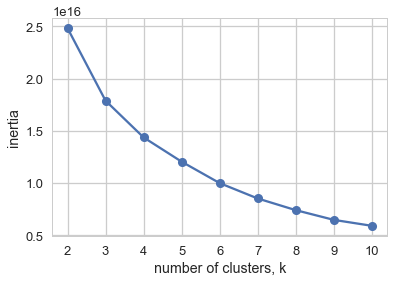

In [27]:
#X = df_employed_clf[df_employed_clf['NOCPRMG']==5].drop(['GENDER'], axis=1)
X = df_employed_clf.drop(['SALARY'], axis=1)

from sklearn.cluster import KMeans

inertia = []
ks=range(2,11)

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X)
     # Append the inertia to the list of inertias
    inertia.append(model.inertia_)
    
plt.plot(ks, inertia, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()



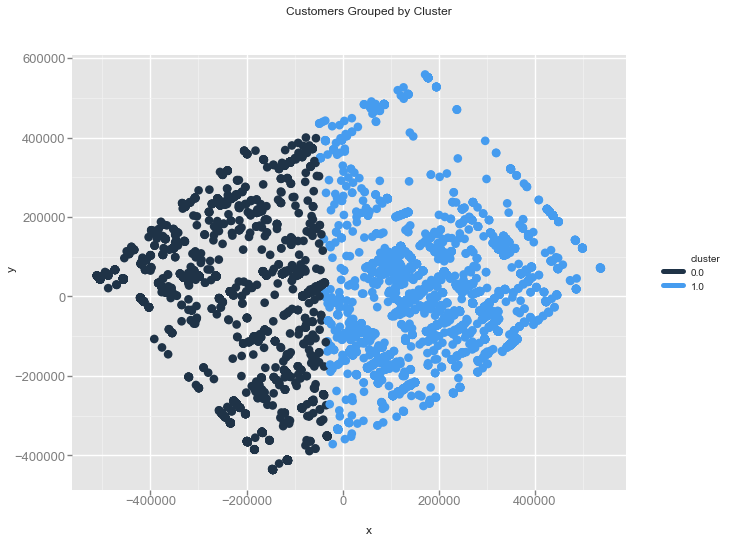

<ggplot: (-9223372036556078269)>

In [61]:
model = KMeans(n_clusters=2)
X_sample = df_employed_clf.sample(frac=0.02, random_state=42)
clster = model.fit_predict(X_sample)

#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X_sample)


X_sample['x'] = pca.fit_transform(X_sample)[:,0]
X_sample['y'] = pca.fit_transform(X_sample)[:,1]
X_sample['cluster'] = clster


from ggplot import *

ggplot(X_sample, aes(x='x', y='y', color='cluster')) + \
    geom_point(size=75) + \
    ggtitle("Customers Grouped by Cluster")
    
    


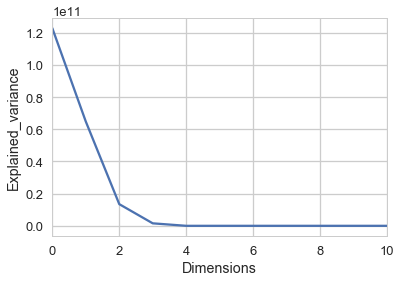

In [62]:
#your turn
# Initialize a new PCA model with a default number of components.
pca = sklearn.decomposition.PCA()
pca.fit(X_sample)

#plot explained variance
plt.plot(pca.explained_variance_)
plt.xlim([0,10])
plt.xlabel('Dimensions')
plt.ylabel('Explained_variance')



In [63]:
X_sample.groupby('cluster').NOCPRMG.value_counts()

cluster  NOCPRMG
0        1.0         803
         2.0         636
         3.0         482
         4.0         476
         7.0         390
         6.0         340
         5.0         107
1        7.0        1928
         6.0        1156
         5.0        1027
         1.0         184
         4.0         178
         2.0          49
         3.0          42
Name: NOCPRMG, dtype: int64

In [175]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.1, min_samples=3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(labels)
print(n_clusters_)

[-1 -1 -1 ..., -1 -1 -1]
28


In [17]:
#classify the field of job from other columns 
#Use dummied data to model

df_employed_field = pd.get_dummies(df_employed_l, columns=['RACETH','NBAMED', 'NBAMEMG', 'NDGMED', 'EMSEC','EMSIZE', 'GOVSUP', 'NDGMEMG', 'OCEDRLP', 'WAPRSM', 'WAPRI', 'WKTRNI', 'WASEC', 'WASCSM', 'SAMPLE', 'HD03Y5', 'DGRDG', 'JOBSATIS','SURID','HRSWKGR','WKSWKGR'], drop_first=True)
df_employed_field_no = df_employed_field[df_employed_field['SALARY']!=0]
X = df_employed_field_no.drop(['NOCPRMG','NOCPR'], axis=1)
y = df_employed_field_no['NOCPRMG']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=100, max_features=25, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[11210   180   160   137  1332   518  1597]
 [  127  7449   608   212   222   679   731]
 [  129   491  5240    62   424   215   467]
 [  138   115    26  7768    65   209  1428]
 [ 1158   138   448    20 14363   372  1422]
 [ 1851  1172   478   310  1698 14048  3441]
 [ 1237   635   413  1215  1864  2168 27189]]
             precision    recall  f1-score   support

        1.0       0.71      0.74      0.72     15134
        2.0       0.73      0.74      0.74     10028
        3.0       0.71      0.75      0.73      7028
        4.0       0.80      0.80      0.80      9749
        5.0       0.72      0.80      0.76     17921
        6.0       0.77      0.61      0.68     22998
        7.0       0.75      0.78      0.77     34721

avg / total       0.74      0.74      0.74    117579



In [37]:
#classify the field of job from other columns 
#Use original data to feed into random forest classifier

X = df_employed_clf.drop(['NOCPRMG','NOCPR'], axis=1)
y = df_employed_clf['NOCPRMG']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=100, max_features=25, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[11407   151   128   131  1344   613  1535]
 [  118  7251   545   206   236   702   753]
 [  116   501  5201    45   444   259   497]
 [  149   128    21  7579    53   252  1483]
 [ 1157   129   468    23 14148   460  1381]
 [ 1872  1227   415   310  1667 14066  3432]
 [ 1270   629   425  1345  1727  2187 26783]]
             precision    recall  f1-score   support

        1.0       0.71      0.75      0.73     15309
        2.0       0.72      0.74      0.73      9811
        3.0       0.72      0.74      0.73      7063
        4.0       0.79      0.78      0.79      9665
        5.0       0.72      0.80      0.76     17766
        6.0       0.76      0.61      0.68     22989
        7.0       0.75      0.78      0.76     34366

avg / total       0.74      0.74      0.74    116969



In [32]:
# classify prime job activity from other not related columns

X = df_employed_clf.drop(['SALARY', 'WAPRSM', 'WAPRI', 'WASEC','WASCSM'], axis=1)
y = df_employed_clf['WAPRSM'].astype('category')

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#initiate a instance for classifier
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[25947  1428  2657  1146   589]
 [  899 14181   386    30   424]
 [ 3363   855 26605   984  1679]
 [  971    57   592  7708   184]
 [ 2213   496  5132   367 18076]]
             precision    recall  f1-score   support

        1.0       0.78      0.82      0.80     31767
        2.0       0.83      0.89      0.86     15920
        3.0       0.75      0.79      0.77     33486
        4.0       0.75      0.81      0.78      9512
        5.0       0.86      0.69      0.77     26284

avg / total       0.79      0.79      0.79    116969



In [155]:
def salary_bracket(ls):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s<50000:
            new_s[i] = 1
        elif s<100000:
            new_s[i] = 2
        elif s<150000:
            new_s[i] = 3
        else:
            new_s[i] = 4
    return new_s

new_salary = salary_bracket(df_employed_no['SALARY'])


In [159]:
df_employed_nod = []
df_employed_nod = df_employed_clf.assign(salary_d=pd.Series(new_salary).values)

In [160]:
df_employed_nod.salary_d = df_employed_nod.salary_d.astype('category')
df_employed_nod=df_employed_nod.drop(['SALARY'], axis=1)
df_employed_nod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389896 entries, 0 to 478746
Data columns (total 38 columns):
YEAR        389896 non-null int64
SAMPLE      389896 non-null int64
SURID       389896 non-null int64
AGE         389896 non-null int64
BIRYR       389896 non-null int64
GENDER      389896 non-null int64
MINRTY      389896 non-null int64
RACETH      389896 non-null int64
BTHUS       389896 non-null int64
CTZUSIN     389896 non-null int64
NBAMED      389896 non-null float64
NBAMEMG     389896 non-null float64
DGRDG       389896 non-null int64
HD03Y5      389896 non-null int64
NDGMED      389896 non-null int64
NDGMEMG     389896 non-null int64
HRSWKGR     389896 non-null float64
WKSWKGR     389896 non-null float64
OCEDRLP     389896 non-null float64
NOCPR       389896 non-null float64
NOCPRMG     389896 non-null float64
JOBSATIS    389896 non-null float64
EMSEC       389896 non-null float64
EMSIZE      389896 non-null float64
GOVSUP      389896 non-null float64
WAPRSM      38989

In [161]:
X = df_employed_nod.drop(['salary_d'], axis=1)
y = df_employed_nod['salary_d']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#initiate a instance for classifier
#clf = LogisticRegression()
clf = RandomForestClassifier(n_estimators=50, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[18779  9426   445   220]
 [ 6053 42656  4438   921]
 [  715 11145  9133  2012]
 [  411  2692  3219  4704]]
             precision    recall  f1-score   support

        1.0       0.72      0.65      0.69     28870
        2.0       0.65      0.79      0.71     54068
        3.0       0.53      0.40      0.45     23005
        4.0       0.60      0.43      0.50     11026

avg / total       0.64      0.64      0.63    116969

